In [67]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

df1 = pd.read_csv('time_series/Data/M2SLMoneyStock.csv', index_col='Date', parse_dates=True)
df1.index.freq = 'MS'

df2 = pd.read_csv('time_series/Data/PCEPersonalSpending.csv',index_col='Date', parse_dates=True)
df2.index.freq = 'MS'

dff = df1.join(df2)
dff.shape

(252, 2)

In [10]:
df = dff.dropna()
df

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1
...,...,...
2015-08-01,12096.8,12394.0
2015-09-01,12153.8,12392.8
2015-10-01,12187.7,12416.1


<AxesSubplot:xlabel='Date'>

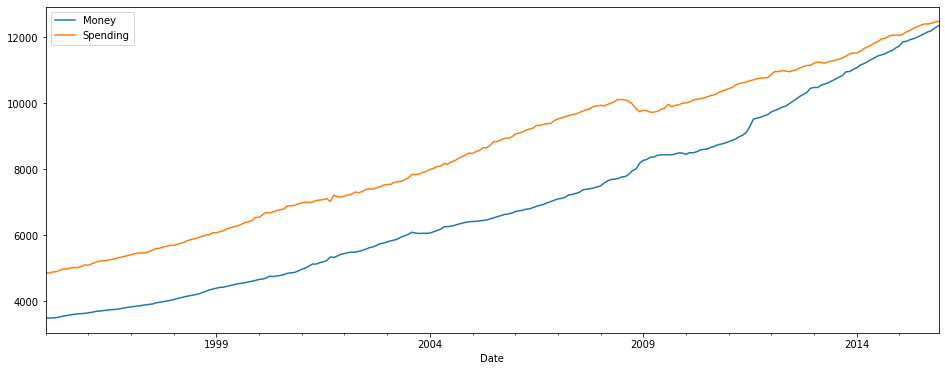

In [11]:
df.plot(figsize=(16,6))

In [12]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [13]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [20]:
#1st oder differencing for non stationary values
df_transformed = df.diff()

In [21]:
adf_test(df_transformed['Money']) #still non stationary

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [22]:
adf_test(df_transformed['Spending']) #It is stationary

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [24]:
df_transformed = df_transformed.diff().dropna()

In [25]:
adf_test(df_transformed['Money']) #Now money and Spending column both are stationary

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [39]:
nobs = 12 #no of observations for test set
train = df_transformed[:-nobs]
test = df_transformed[-nobs:] #start -12 from the end to true end of df

## Gridsearch for order p AR of VAR model

In [29]:
model = VAR(train)

for p in [1,2,3,4,5,6,7]: # or range(8)
    results = model.fit(p)
    print(f'Order {p}')
    print(f'AIC: {results.aic}')
    print('############################') 
    print('\n') #AIC 1st decreases for complex models and then it increases as the complexity increases more, so we need to
    #stop at a poiint of minimum AIC(p=5)

Order 1
AIC: 14.178610495220896
############################


Order 2
AIC: 13.955189367163703
############################


Order 3
AIC: 13.849518291541038
############################


Order 4
AIC: 13.827950574458281
############################


Order 5
AIC: 13.78730034460964
############################


Order 6
AIC: 13.799076756885809
############################


Order 7
AIC: 13.797638727913972
############################




In [30]:
results = model.fit(5)
results.summary() #k=2, below for money and spending

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Feb, 2023
Time:                     13:49:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

In [35]:
train.values[-5:]

array([[-31.9,  40.3],
       [  5.6, -70.7],
       [ 25.5,  52.5],
       [-21.3, -37.2],
       [ 39.5, -17.8]])

In [37]:
lagged_values = train.values[-5:]
z = results.forecast(y=lagged_values, steps=12)
# Here forecast takes no of steps(forecasting duration) and lagged values y parameter(pxk),
# p denotes the lag order, k is the no. of time series terms(here 2), here y is 5 lagged values just before the test set starts.
z

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

In [40]:
idx = pd.date_range('2015-01-01', periods=12, freq='MS')
df_forecast = pd.DataFrame(data=z, index=idx, columns=['Money_2diff','Spending_2diff'])
df_forecast

,Money_2diff,Spending_2diff
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


## Invert the Transformation
Remember that the forecasted values represent second-order differences. To compare them to the original data we have to roll back each difference. To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values. When working with second-order differences we first must perform this operation on the most recent first-order difference.

Here we'll use the <tt>nobs</tt> variable we defined during the train/test/split step.

In [42]:
#Inverting the transformation for money and spending column
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (dff['Money'].iloc[-nobs-1]-dff['Money'].iloc[-nobs-2]) + df_forecast['Money_2diff'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = dff['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending_2diff'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [43]:
df_forecast.head()

,Money_2diff,Spending_2diff,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


<AxesSubplot:xlabel='Date'>

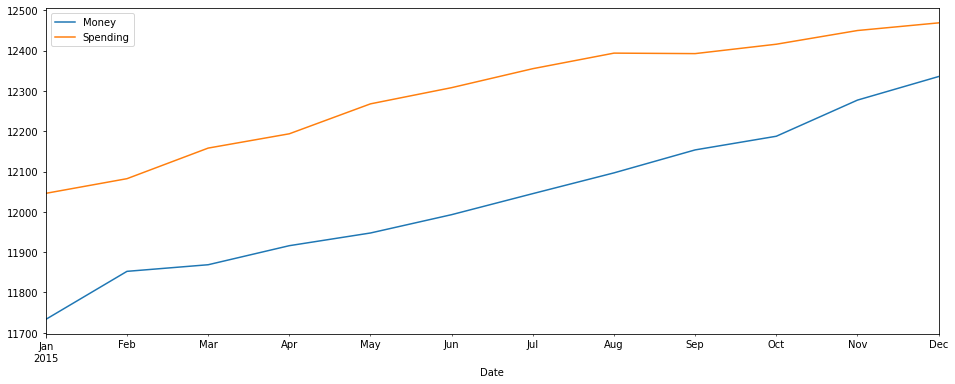

In [56]:
test_range = dff[-nobs:]
test_range.plot(figsize=(16,6)) #True values for the range in the test set

<AxesSubplot:>

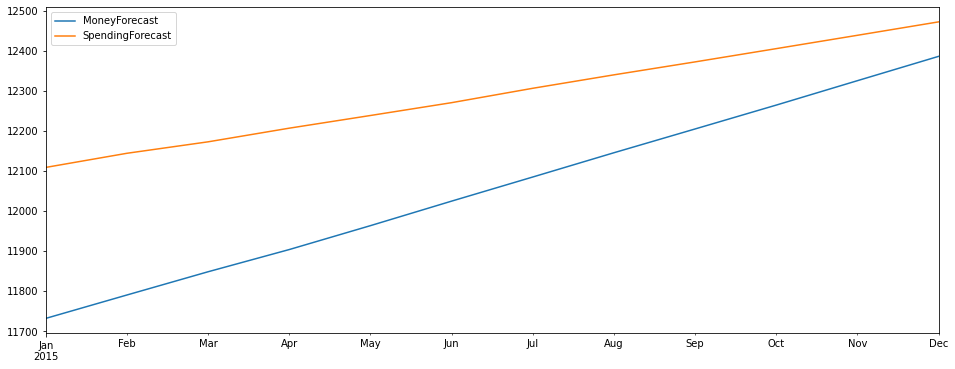

In [57]:
df_forecast[['MoneyForecast','SpendingForecast']].plot(figsize=(16,6))

<AxesSubplot:xlabel='Date'>

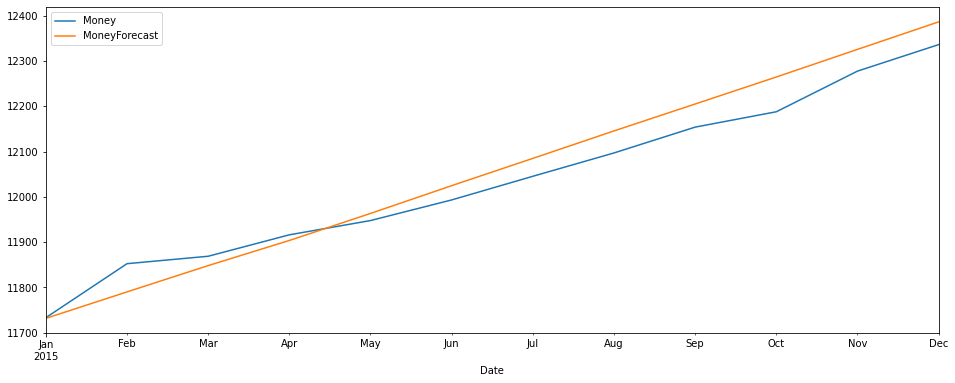

In [59]:
test_range['Money'].plot(legend=True, figsize=(16,6))
df_forecast['MoneyForecast'].plot(legend=True)

<AxesSubplot:xlabel='Date'>

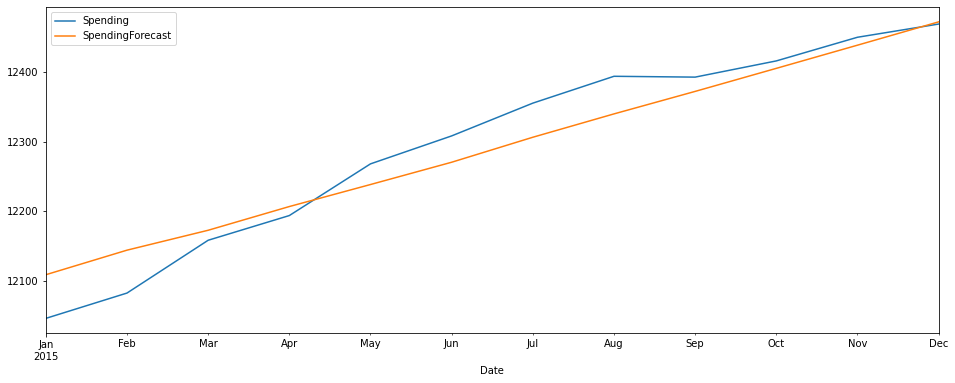

In [60]:
test_range['Spending'].plot(legend=True, figsize=(16,6))
df_forecast['SpendingForecast'].plot(legend=True)

In [62]:
rmse(test_range['Money'], df_forecast['MoneyForecast'])

43.71049653558893

In [63]:
test_range['Money'].mean()

12034.008333333333

In [64]:
rmse(test_range['Spending'], df_forecast['SpendingForecast'])

37.00117516940808

In [65]:
test_range['Spending'].mean()

12294.533333333335

## ## Let's compare these results to individual AR(5) models

In [66]:
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
modelM = AutoReg(train['Money'])
AR5fit1 = modelM.fit(maxlag=5,method='mle')
print(f'Lag: {AR5fit1.k_ar}')
print(f'Coefficients:\n{AR5fit1.params}')

In [ ]:
start=len(train)
end=len(train)+len(test)-1
z1 = pd.DataFrame(AR5fit1.predict(start=start, end=end, dynamic=False),columns=['Money'])
z1

In [ ]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()
z1

In [ ]:
RMSE3 = rmse(df['Money'][-nobs:], z1['MoneyForecast'])

print(f'Money VAR(5) RMSE: {RMSE1:.3f}')
print(f'Money  AR(5) RMSE: {RMSE3:.3f}')

In [ ]:
modelS = AR(train['Spending'])
AR5fit2 = modelS.fit(maxlag=5,method='mle')
print(f'Lag: {AR5fit2.k_ar}')
print(f'Coefficients:\n{AR5fit2.params}')

In [ ]:
z2 = pd.DataFrame(AR5fit2.predict(start=start, end=end, dynamic=False),columns=['Spending'])
z2

In [ ]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()
z2

In [ ]:
RMSE4 = rmse(df['Spending'][-nobs:], z2['SpendingForecast'])

print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')
print(f'Spending  AR(5) RMSE: {RMSE4:.3f}')

<strong>CONCLUSION:</strong> It looks like the VAR(5) model did <em>not</em> do better than the individual AR(5) models.

## VARMA Model(p,q)

In [68]:
dff

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1
...,...,...
2015-08-01,12096.8,12394.0
2015-09-01,12153.8,12392.8
2015-10-01,12187.7,12416.1


## Test for stationarity, perform any necessary transformations
In ARMA model we applied the augmented Dickey-Fuller test and found that a second-order difference achieved stationarity. In this section we'll perform the <strong>auto_arima</strong> prediction to identify optimal $p$ and $q$ orders.

In [70]:
auto_arima(dff['Money'], maxiter=1000) #p=1,q=1,d=2

ARIMA(maxiter=1000, order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [71]:
auto_arima(dff['Spending'],maxiter=1000)#p=1,q=2,d=1

ARIMA(maxiter=1000, order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

In [72]:
df_transformed = dff.diff().diff() # 2 times differencing to make both time series stationary
df_transformed =df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [73]:
nobs = 12 #no of observations for test set
train = df_transformed[:-nobs]
test = df_transformed[-nobs:] #start -12 from the end to true end of df
print(train.shape, test.shape)

(238, 2) (12, 2)


In [74]:
#Fit the VARMA(1,2) Model
model = VARMAX(train, order=(1,2), trend='c') #for constant linear trend
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.480
,+ intercept,AIC,4606.961
Date:,"Thu, 09 Feb 2023",BIC,4665.989
Time:,23:17:30,HQIC,4630.750
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.97, 0.01",Jarque-Bera (JB):,"531.35, 115.32"
Prob(Q):,"0.32, 0.91",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.57, 2.89",Skew:,"1.31, -0.33"


## Predict the next 12 values
Unlike the VAR model we used in the previous section, the VARMAX <tt>.forecast()</tt> function won't require that we pass in a number of previous observations, and it will provide an extended DateTime index.

In [76]:
df_forecast = results.forecast(12) #differenced predictions
df_forecast

,Money,Spending
2015-01-01,-11.106075,36.707137
2015-02-01,-11.460998,-3.633662
2015-03-01,1.213471,-0.280236
2015-04-01,-1.631636,-0.136001
2015-05-01,1.002661,0.213726
2015-06-01,-0.361254,0.095779
2015-07-01,0.485358,0.183737
2015-08-01,-0.007347,0.135421
2015-09-01,0.285785,0.164763
2015-10-01,0.112716,0.147560


In [80]:
#Inverting the transformation for money and spending column
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (dff['Money'].iloc[-nobs-1]-dff['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = dff['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [81]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-11.106075,36.707137,67.493925,11658.993925,47.307137,12098.707137
2015-02-01,-11.460998,-3.633662,56.032928,11647.532928,43.673475,12095.073475
2015-03-01,1.213471,-0.280236,57.246399,11648.746399,43.393238,12094.793238
2015-04-01,-1.631636,-0.136001,55.614763,11647.114763,43.257237,12094.657237
2015-05-01,1.002661,0.213726,56.617423,11648.117423,43.470963,12094.870963
2015-06-01,-0.361254,0.095779,56.256170,11647.756170,43.566742,12094.966742
2015-07-01,0.485358,0.183737,56.741527,11648.241527,43.750479,12095.150479
2015-08-01,-0.007347,0.135421,56.734180,11648.234180,43.885899,12095.285899
2015-09-01,0.285785,0.164763,57.019965,11648.519965,44.050663,12095.450663
2015-10-01,0.112716,0.147560,57.132681,11648.632681,44.198223,12095.598223


In [85]:
df_concat = pd.concat([dff.iloc[-12:], df_forecast[['MoneyForecast','SpendingForecast']]], axis=1)
df_concat

,Money,Spending,MoneyForecast,SpendingForecast
2015-01-01,11733.2,12046.0,11658.993925,12098.707137
2015-02-01,11852.4,12082.4,11647.532928,12095.073475
2015-03-01,11868.8,12158.3,11648.746399,12094.793238
2015-04-01,11916.1,12193.8,11647.114763,12094.657237
2015-05-01,11947.6,12268.1,11648.117423,12094.870963
2015-06-01,11993.1,12308.3,11647.756170,12094.966742
2015-07-01,12045.3,12355.4,11648.241527,12095.150479
2015-08-01,12096.8,12394.0,11648.234180,12095.285899
2015-09-01,12153.8,12392.8,11648.519965,12095.450663
2015-10-01,12187.7,12416.1,11648.632681,12095.598223


<AxesSubplot:xlabel='Date'>

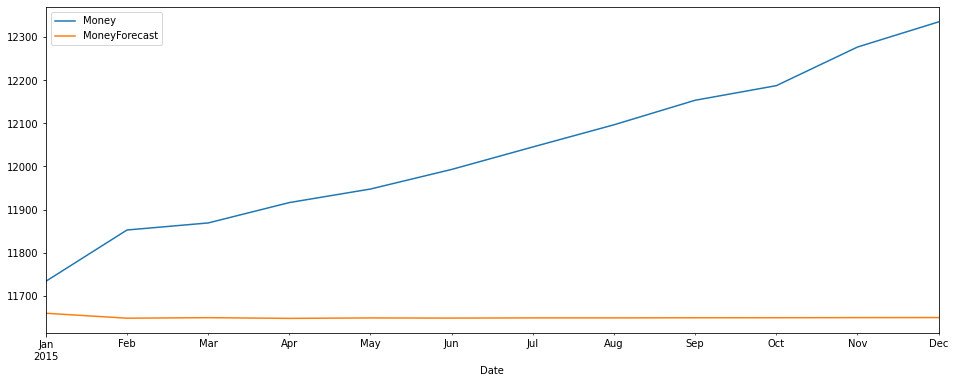

In [88]:
test_range = dff['Money'].iloc[-nobs:]
test_range.plot(figsize=(16,6), legend=True).autoscale(axis='x', tight=True)
df_forecast['MoneyForecast'].plot(figsize=(16,6),legend=True) #Not performing well

<AxesSubplot:xlabel='Date'>

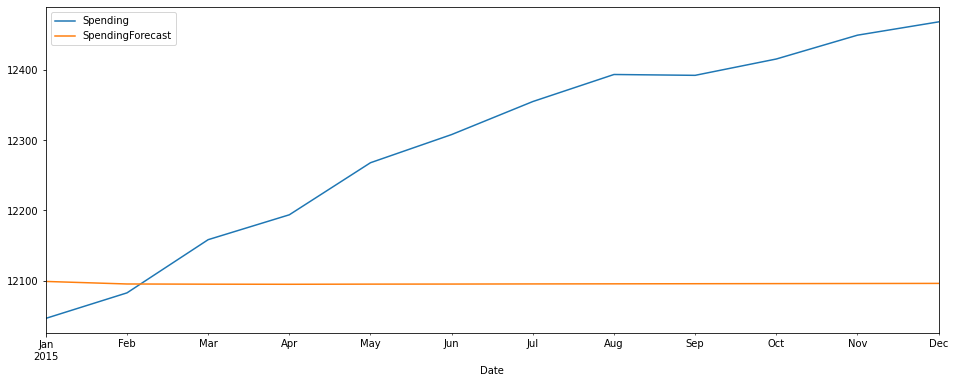

In [90]:
test_range = dff['Spending'].iloc[-nobs:]
test_range.plot(figsize=(16,6), legend=True).autoscale(axis='x', tight=True)
df_forecast['SpendingForecast'].plot(figsize=(16,6),legend=True) #Not performing well

In [91]:
RMSE1 = rmse(dff['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 423.171


In [92]:
RMSE2 = rmse(dff['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 242.427


Clearly these results are less accurate than our earlier VAR(5) model.
## Let's compare these results to individual ARMA(1,2) models

In [ ]:
#Money
model = ARMA(train['Money'],order=(1,2))
results = model.fit()
results.summary()

In [ ]:
start=len(train)
end=len(train)+len(test)-1
z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)
z1

In [ ]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()
z1

In [ ]:
RMSE3 = rmse(df['Money'][-nobs:], z1['MoneyForecast'])

print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE3:.3f}')

In [ ]:
#Spending
model = ARMA(train['Spending'],order=(1,2))
results = model.fit()
results.summary()

In [ ]:
start=len(train)
end=len(train)+len(test)-1
z2 = results.predict(start=start, end=end).rename('Spending')
z2 = pd.DataFrame(z2)
z2

In [ ]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()
z2

In [ ]:
RMSE4 = rmse(df['Spending'][-nobs:], z2['SpendingForecast'])

print(f'Spending VARMA(1,2) RMSE: {RMSE2:.3f}')
print(f'Spending  ARMA(1,2) RMSE: {RMSE4:.3f}')

<strong>CONCLUSION:</strong> It looks like the VARMA(1,2) model did a relatively poor job compared to simpler alternatives. This tells us that there is little or no interdepence between Money Stock and Personal Consumption Expenditures, at least for the timespan we investigated. This is helpful! By fitting a model and getting poor results we know more about the data than we did before.